In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33          10228        394  1.0              
juhibhojani/house-price                                     House Price                                        7MB  2023-08-02 16:51:21           1397         51  0.9411765        
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41          11755        201  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Predic

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign #--force

100% 612M/612M [00:31<00:00, 21.5MB/s]
100% 612M/612M [00:31<00:00, 20.5MB/s]


In [ ]:
!mkdir Dataset
!unzip -q gtsrb-german-traffic-sign.zip -d /content/Dataset

**Preprocessing Image**

In [ ]:
images = []
labels = []
classes = 43

for i in range(classes):
    path = '/content/Dataset/train/'+ str(i)
    raw_images = os.listdir(path)
    for img in raw_images:
        try:
            image = Image.open(path + '/'+ img)
            image = image.resize((30,30))
            image = np.array(image)
            images.append(image)
            labels.append(i)
        except Exception as e:
            print(e)

#converting to numpy array
images = np.array(images)
labels = np.array(labels)

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [ ]:
print('Shape of Image Data: ' + str(images.shape))
print('Shape of Label Data: ' + str(labels.shape))

Shape of Image Data: (39209, 30, 30, 3)
Shape of Label Data: (39209,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.25, random_state = 42, shuffle=True)

print("X_train.shape", x_train.shape)
print("X_valid.shape", x_test.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_test.shape)

X_train.shape (29406, 30, 30, 3)
X_valid.shape (9803, 30, 30, 3)
y_train.shape (29406,)
y_valid.shape (9803,)


**Convert Labels to onehot Encoding**

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

**Building Model**

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(30,30,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))

model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

# We have 43 classes that's why we have defined 43 in the dense
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 11, 11, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          1

**Compilation of Model**

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    epochs = 20
    batch_size = 32
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_test, y_test))

Epoch 1/20
919/919 [==============================] - 23s 9ms/step - loss: 0.6811 - accuracy: 0.8195 - val_loss: 0.0882 - val_accuracy: 0.9720
Epoch 2/20
919/919 [==============================] - 8s 9ms/step - loss: 0.1125 - accuracy: 0.9664 - val_loss: 0.0531 - val_accuracy: 0.9841
Epoch 3/20
919/919 [==============================] - 7s 8ms/step - loss: 0.0758 - accuracy: 0.9776 - val_loss: 0.0434 - val_accuracy: 0.9874
Epoch 4/20
919/919 [==============================] - 8s 9ms/step - loss: 0.0582 - accuracy: 0.9826 - val_loss: 0.0457 - val_accuracy: 0.9875
Epoch 5/20
919/919 [==============================] - 9s 10ms/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0249 - val_accuracy: 0.9919
Epoch 6/20
919/919 [==============================] - 8s 8ms/step - loss: 0.0445 - accuracy: 0.9862 - val_loss: 0.0172 - val_accuracy: 0.9946
Epoch 7/20
919/919 [==============================] - 8s 9ms/step - loss: 0.0429 - accuracy: 0.9866 - val_loss: 0.0312 - val_accuracy: 0.9905
Epoc

**Accuracy**

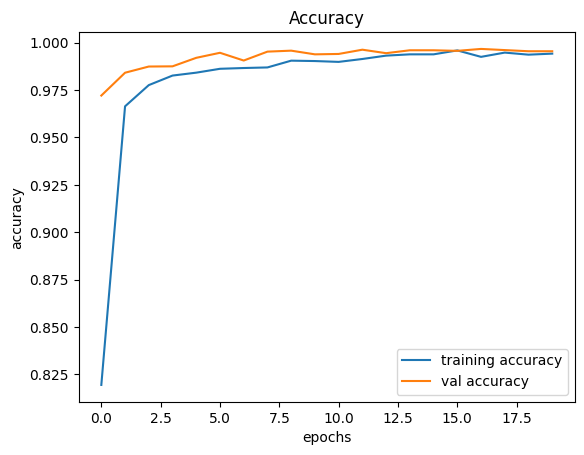

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**Loss**

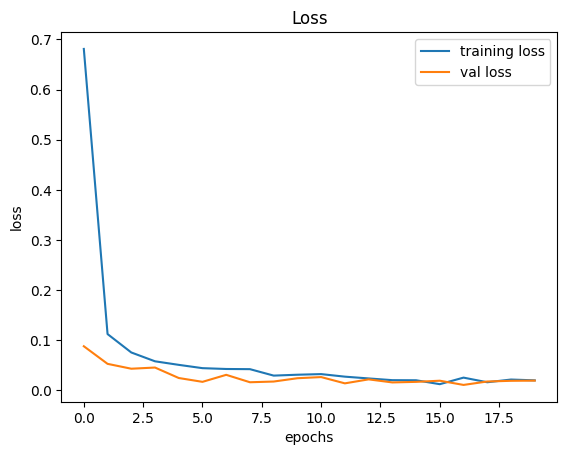

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**Testing And Accuracy**

In [ ]:
# Importing the test dataset
y_test = pd.read_csv('/content/Dataset/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/Dataset/'+img)
        image = image.resize([30, 30])
        data.append(np.array(image))

X_test = np.array(data)

In [ ]:
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print('Accuracy: ' + str(accuracy_score(labels, pred)*100) + ' %')

395/395 [==============================] - 1s 3ms/step
Accuracy: 97.78305621536025 %


**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

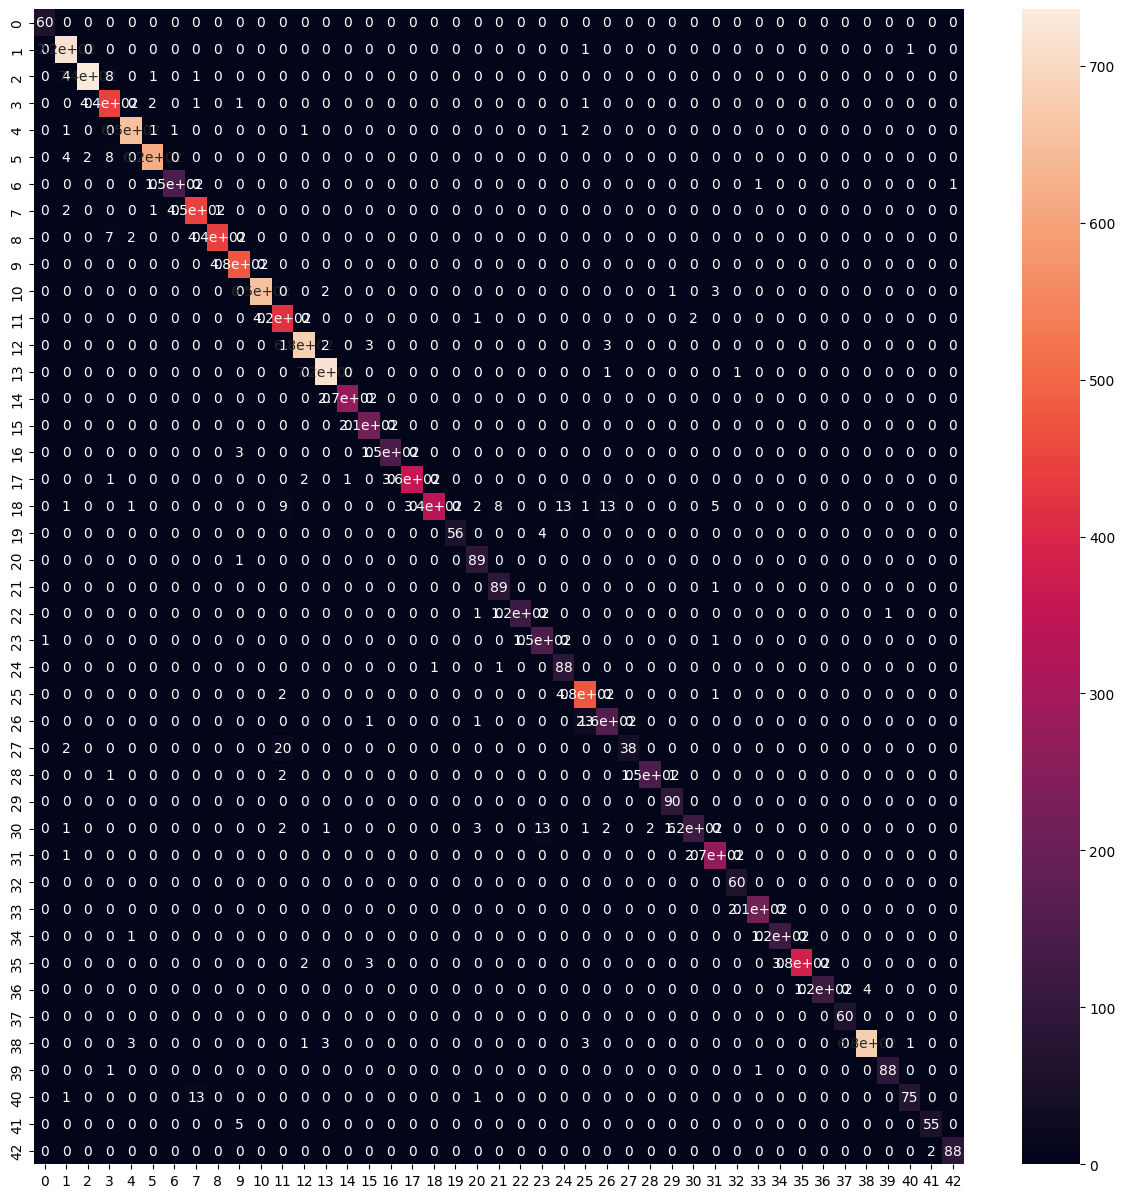

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True)

In [ ]:
model.save("./trained/TSR.h5")

**Loading the model**

In [ ]:
from keras.models import load_model
model = load_model('./trained/TSR.h5')

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
def test_on_img(img):
    data=[]
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))
    x_test=np.array(data)
    y_pred = np.argmax(model.predict(x_test), axis=-1)
    return image, y_pred

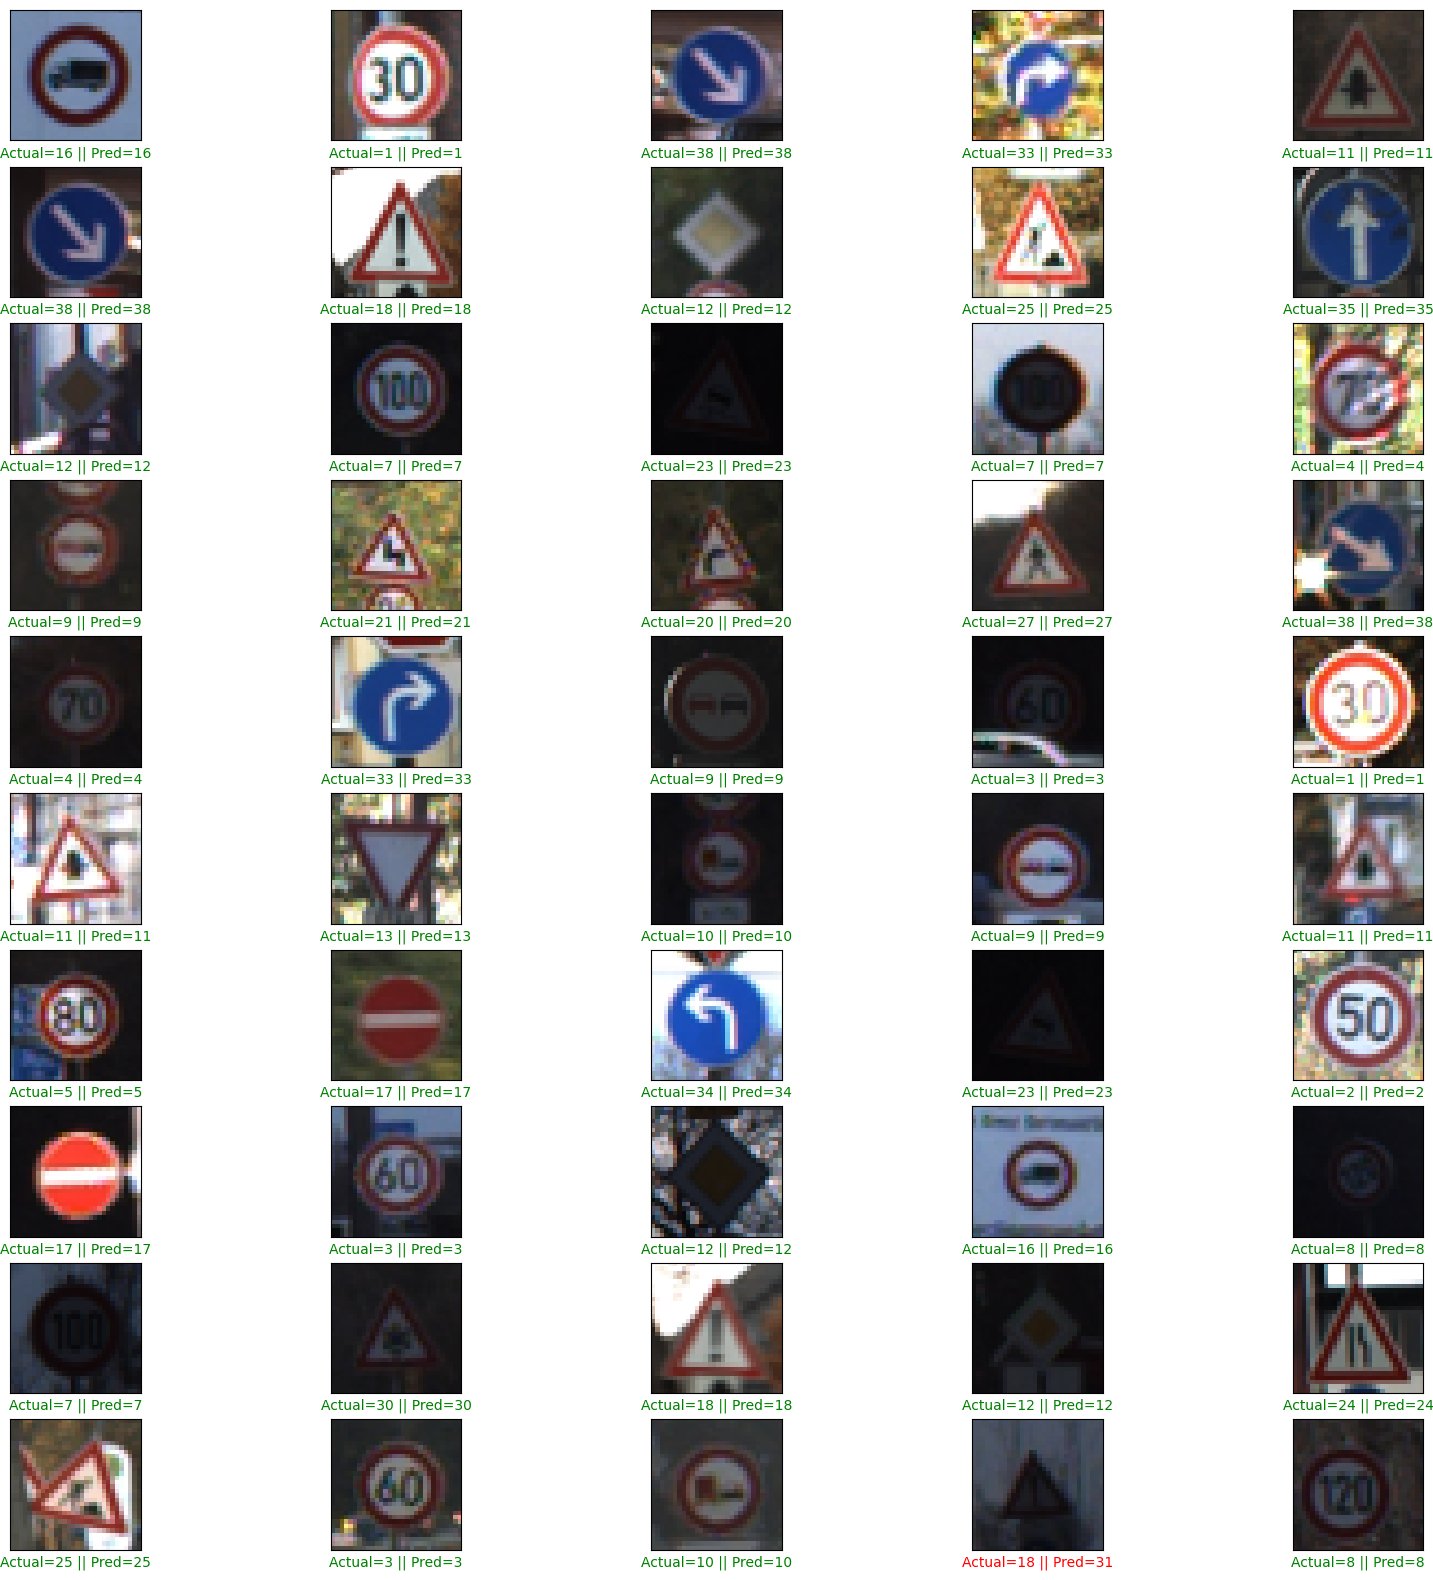

In [ ]:
plt.figure(figsize = (20, 20))
start_index = 0

for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()